Config loaded successfully.
Using Regime Map for sizing: {0: 2.0, 1: 1.0, 2: 0.0}

Testing with Base Size: 1, Confidence Threshold: 0.55
----------------------------------------
Desc: Low confidence                      | Conf: 0.50, Regime: 0 -> Size: 0
Desc: Medium confidence, Regime 0 (Good?) | Conf: 0.65, Regime: 0 -> Size: 2
Desc: High confidence, Regime 0 (Good?)   | Conf: 0.85, Regime: 0 -> Size: 2
Desc: Medium confidence, Regime 1 (Neutral?) | Conf: 0.65, Regime: 1 -> Size: 1
Desc: High confidence, Regime 1 (Neutral?) | Conf: 0.85, Regime: 1 -> Size: 1
Desc: Medium confidence, Regime 2 (Bad?)  | Conf: 0.65, Regime: 2 -> Size: 0
Desc: High confidence, Regime 2 (Bad?)    | Conf: 0.85, Regime: 2 -> Size: 0


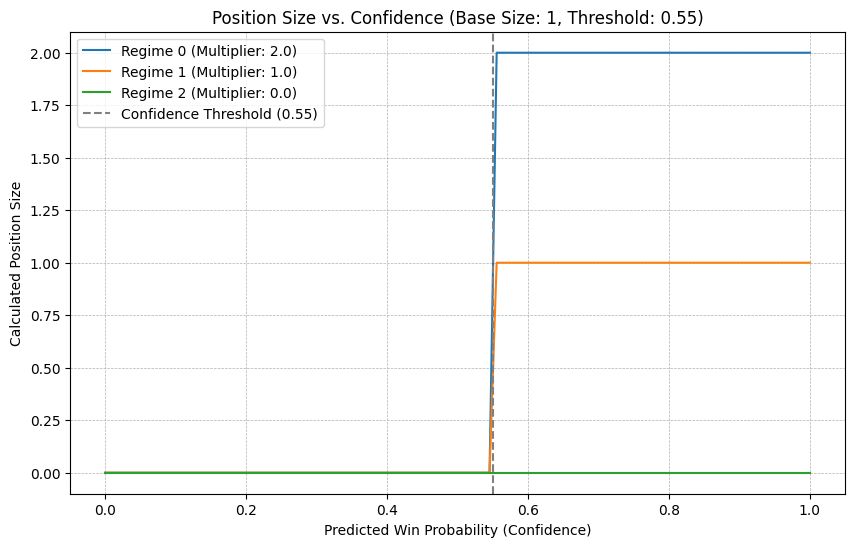

In [1]:
# %% [markdown]
# # 5. Position Sizing Logic
#
# **Purpose:** Define and test the logic for adjusting position size based on model confidence and/or market regime.

# %%
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom functions
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from position_sizing import get_position_size

# %% [markdown]
# ## Load Configuration

# %%
CONFIG_PATH = '../config/config.yaml'
try:
    with open(CONFIG_PATH, 'r') as f:
        config = yaml.safe_load(f)
    print("Config loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Config file not found at {CONFIG_PATH}")
    config = None
except Exception as e:
    print(f"ERROR loading config: {e}")
    config = None

if config is None:
    raise ValueError("Failed to load configuration.")

# Position Sizing Parameters
POS_SIZING_PARAMS = config['position_sizing_params']
BASE_SIZE = config['strategy_params']['basePositionSize']
CONF_THRESHOLD = POS_SIZING_PARAMS['confidence_threshold']
REGIME_MAP = POS_SIZING_PARAMS.get('regime_multipliers', None) # Use .get for safety

if REGIME_MAP:
    # Convert keys to integers if they were loaded as strings from YAML
    REGIME_MAP = {int(k): v for k, v in REGIME_MAP.items()}
    print(f"Using Regime Map for sizing: {REGIME_MAP}")
else:
    print("No Regime Map defined in config, using confidence only (if applicable) or fixed size.")

# %% [markdown]
# ## Test the Sizing Function

# %%
# Example Scenarios
test_cases = [
    {'confidence': 0.50, 'regime': 0, 'description': 'Low confidence'},
    {'confidence': 0.65, 'regime': 0, 'description': 'Medium confidence, Regime 0 (Good?)'},
    {'confidence': 0.85, 'regime': 0, 'description': 'High confidence, Regime 0 (Good?)'},
    {'confidence': 0.65, 'regime': 1, 'description': 'Medium confidence, Regime 1 (Neutral?)'},
    {'confidence': 0.85, 'regime': 1, 'description': 'High confidence, Regime 1 (Neutral?)'},
    {'confidence': 0.65, 'regime': 2, 'description': 'Medium confidence, Regime 2 (Bad?)'},
    {'confidence': 0.85, 'regime': 2, 'description': 'High confidence, Regime 2 (Bad?)'},
]

print(f"\nTesting with Base Size: {BASE_SIZE}, Confidence Threshold: {CONF_THRESHOLD}")
print("-" * 40)
for case in test_cases:
    size = get_position_size(
        confidence=case['confidence'],
        regime=case['regime'],
        base_size=BASE_SIZE,
        confidence_threshold=CONF_THRESHOLD,
        regime_map=REGIME_MAP
    )
    print(f"Desc: {case['description']:<35} | Conf: {case['confidence']:.2f}, Regime: {case['regime']} -> Size: {size}")

# %% [markdown]
# ## Visualize Sizing Logic (Example)
# Show how size changes with confidence for different regimes.

# %%
if REGIME_MAP:
    plt.figure(figsize=(10, 6))
    confidence_levels = np.linspace(0.0, 1.0, 100)

    for regime_label, multiplier in REGIME_MAP.items():
        sizes = [get_position_size(conf, regime_label, BASE_SIZE, CONF_THRESHOLD, REGIME_MAP) for conf in confidence_levels]
        plt.plot(confidence_levels, sizes, label=f'Regime {regime_label} (Multiplier: {multiplier})')

    plt.xlabel('Predicted Win Probability (Confidence)')
    plt.ylabel('Calculated Position Size')
    plt.title(f'Position Size vs. Confidence (Base Size: {BASE_SIZE}, Threshold: {CONF_THRESHOLD})')
    plt.axvline(CONF_THRESHOLD, color='grey', linestyle='--', label=f'Confidence Threshold ({CONF_THRESHOLD})')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=-0.1) # Ensure 0 is visible
    plt.show()
else:
    print("\nCannot visualize regime-based sizing as REGIME_MAP is not defined.")
    # Optional: Visualize size based only on confidence if that logic exists in get_position_size

# %% [markdown]
# ---
# End of Notebook 05
# ---